# Information

In this exercise we will computationally determine the area of the Mandelbrot set. 

ALL IMPORTS HERE:

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

ALL GLOBAL CONSTANTS HERE:

In [3]:
# Section (i)
MAX_ITERATIONS = 255
STANDARD_REAL_MIN = -2
STANDARD_REAL_MAX = 1
STANDARD_COMPLEX_MIN = -1.5
STANDARD_COMPLEX_MAX = 1.5

# Section (ii)

# Section (iii)

# Section (iv)

### (i) Visualizing the Mandelbrot set

(~Ayman: feel free to change name of variables, add docstrings, change code, etc... I will try to do this later. Also, we should read PEP 8.)

In [38]:
def mandelbrot_sequence(c,iter):
    """
    [I forgot which format was prominent.]
        Returns the iteration after which the Mandelbrot sequence diverges. 
        It can be easily shown that this occers when |z_n| > 2. 

        Keyword arguments:
        c -- complex number (being tested whether it is in the Mandelbrot set) 
    """
    z = 0
    counter = 0
    while np.abs(z) <= 2 and counter < iter:
        counter += 1
        z = z ** 2 + c
    return counter

In [5]:
print(mandelbrot_sequence(c=1,iter=MAX_ITERATIONS))

3


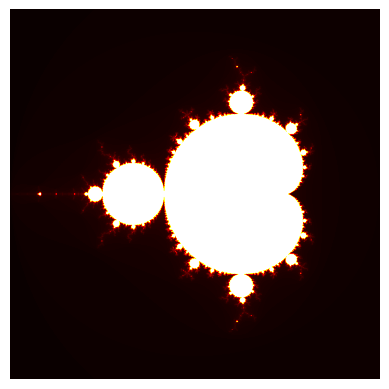

In [6]:
def plot_mandelbrot_fractal(real_min, real_max, imaginary_min, imaginary_max, width, height):
    """
        Inspiration from wiki python + pseudo code. (I will add a description later.)
        I will also add comments later when I have time.
    """
    image = np.zeros(shape = (height, width))

    real_range = np.linspace(real_min, real_max, width)
    imaginary_range = np.linspace(imaginary_min, imaginary_max, height)

    for i, real in enumerate(real_range):
        for j, imaginary in enumerate(imaginary_range):
            c = complex(real, imaginary)
            image[j, i] = mandelbrot_sequence(c=c,iter=MAX_ITERATIONS)

    _, ax = plt.subplots()
    ax.imshow(image, cmap="hot", extent=(real_min, real_max, imaginary_min, imaginary_max))
    ax.axis("off")
    plt.show()

# change width and height accordingly
plot_mandelbrot_fractal(STANDARD_REAL_MIN, STANDARD_REAL_MAX, STANDARD_COMPLEX_MIN, STANDARD_COMPLEX_MAX, 1000, 850)

            


### (ii) Finding the area using Monte-Carlo:

In [40]:
def mandelbrot_area(num_iteration, num_sample, real_min, real_max, imaginary_min, imaginary_max):
    real_parts = np.random.uniform(real_min, real_max, num_sample)
    imag_parts = np.random.uniform(imaginary_min, imaginary_max, num_sample)
    complex_values = real_parts + 1j * imag_parts

    iterations = np.array([mandelbrot_sequence(c, num_iteration) for c in complex_values])
    bounded = np.count_nonzero(iterations == num_iteration)
    
    domain_area = (real_max - real_min) * (imaginary_max - imaginary_min)
    area = domain_area * bounded / num_sample

    return area


In [48]:
num_iterations = np.linspace(50, 500, num=50, dtype=int).astype(int)
num_samples = np.linspace(100, 1000, num=50, dtype=int).astype(int)

results = np.zeros((len(num_iterations), len(num_samples)))
# tqdm for progress bar
for it_idx, iteration in enumerate(tqdm.tqdm(num_iterations, desc="Iterations Progress")):
    for sample_idx, sample in enumerate(num_samples):
        results[it_idx,sample_idx] = mandelbrot_area(iteration, sample, STANDARD_REAL_MIN, STANDARD_REAL_MAX, STANDARD_COMPLEX_MIN, STANDARD_COMPLEX_MAX)


Iterations Progress: 100%|██████████| 50/50 [01:30<00:00,  1.81s/it]


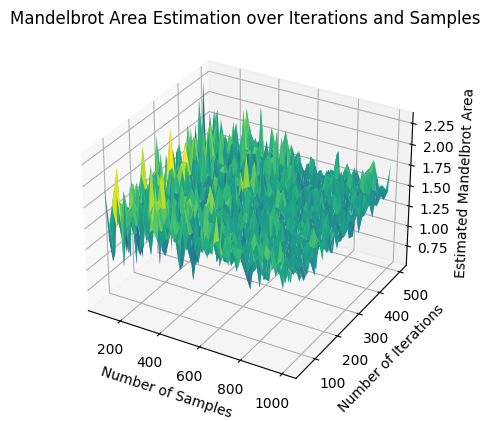

In [49]:
# print(results)
# Plotting the results in 3D
X, Y = np.meshgrid(num_samples, num_iterations)
Z = results

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

# Label axes
ax.set_xlabel("Number of Samples")
ax.set_ylabel("Number of Iterations")
ax.set_zlabel("Estimated Mandelbrot Area")

plt.title("Mandelbrot Area Estimation over Iterations and Samples")
plt.show()